In [1]:
import datasets as hfds

import minai.datasets as minds
import minai.data as mind
import minai.sampler as mins
import minai.plot as minplt

minplt.default_cmap("gray")
minplt.default_title_color("white")

In [24]:
%load_ext autoreload
%autoreload 2

In [2]:
dsd = minds.hf_load(minds.HF_DATASETS.FASHION_MNIST)

Found cached dataset fashion_mnist (/home/nblzv/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
tdsd = dsd.with_transform(
    mind.HFTransform.ff_img_decode_to_tensor(mind.first_value(dsd).features),
).cast_column("image", hfds.Image(decode=False))

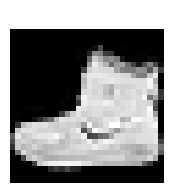

In [49]:
dl = mind.DataLoader.hf(tdsd["train"])
batch = mind.first(dl)
minplt.show_img(batch[0][0], minplt.PlotOpts(title=batch[1][0], figsize=(2, 2)))

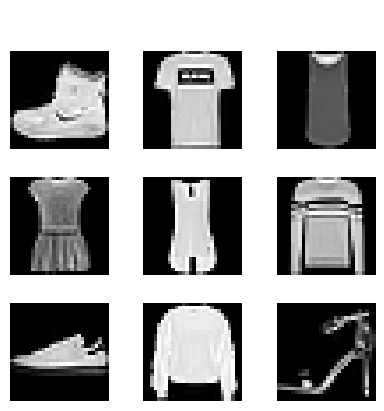

In [52]:
opts = minplt.PlotOpts(rows=3, 
                       cols=3, 
                       figsize=(4, 4),
                       title="Batch",
                       titles=[[x, -x] for x in batch[1]])
minplt.show_batch(batch[0], opts)

In [60]:
dls = mind.DataLoaders.hf(tdsd, mins.SIO(16))
dls.train

DataLoader(ds=Dataset({
    features: ['image', 'label'],
    num_rows: 60000
}),
    CMTO(SIO(batch_size=16, shuffle=False, drop_last=False),
        getitem_func=Dataset.__getitem__,
        collate_func=HFCollate.__call__,
        num_workers=4,
        max_available_batches=2,
        chunk_size_per_thread=4,
        is_hf_ds=True)
)